In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose,Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras import backend as K

In [2]:
(x_train,y_train),(x_test,y_test)=mnist.load_data() # MNIST를 읽고 신경망에 입력할 준비
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
x_train=np.reshape(x_train,(len(x_train),28,28,1))
x_test=np.reshape(x_test,(len(x_test),28,28,1))

zdim=32           					# 잠복 공간의 차원

In [12]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], zdim), mean=0.0, stddev=0.1)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
encoder_input=Input(shape=(28,28,1))		# 인코더
x=Conv2D(32,(3,3),activation='relu',padding='same',strides=(1,1))(encoder_input)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Flatten()(x)
z_mean=Dense(zdim)(x)
z_log_var=Dense(zdim)(x)
encoder_output = Lambda(sampling, output_shape=(zdim,))([z_mean, z_log_var])
model_encoder=Model(encoder_input,[z_mean,z_log_var,encoder_output])

decoder_input=Input(shape=(zdim,))		# 디코더
x=Dense(3136)(decoder_input)
x=Reshape((7,7,64))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(1,(3,3),activation='sigmoid',padding='same',strides=(1,1))(x)
decoder_output=x
model_decoder=Model(decoder_input,decoder_output)

In [18]:
# Custom VAE Model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        x = data[0] if isinstance(data, tuple) else data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2,))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Instantiate and compile the VAE
vae = VAE(model_encoder, model_decoder)
vae.compile(optimizer='adam')

# Train the model
vae.fit(x_train, x_train, epochs=50, batch_size=128)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - kl_loss: 4.5537 - loss: 72.9869 - reconstruction_loss: 68.4332
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 4.6595 - loss: 68.4517 - reconstruction_loss: 63.7923
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 4.6782 - loss: 67.1965 - reconstruction_loss: 62.5183
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 4.6949 - loss: 66.4997 - reconstruction_loss: 61.8048
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 4.6991 - loss: 65.8340 - reconstruction_loss: 61.1349
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 4.6897 - loss: 65.5255 - reconstruction_loss: 60.8357
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 4.6886 - loss: 65.1997 - reconstruction_loss: 60.5111
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 4.6797 - loss: 64.9034 - reconstruction_loss: 60.2237
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - 

In [19]:
# Generate samples
i = np.random.randint(x_test.shape[0])
j = np.random.randint(x_test.shape[0])
x = np.array([x_test[i], x_test[j]])
z = model_encoder.predict(x)[2]

zz = np.zeros((11, zdim))
alpha = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for i in range(11):
    zz[i] = (1.0 - alpha[i]) * z[0] + alpha[i] * z[1]

gen = model_decoder.predict(zz)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


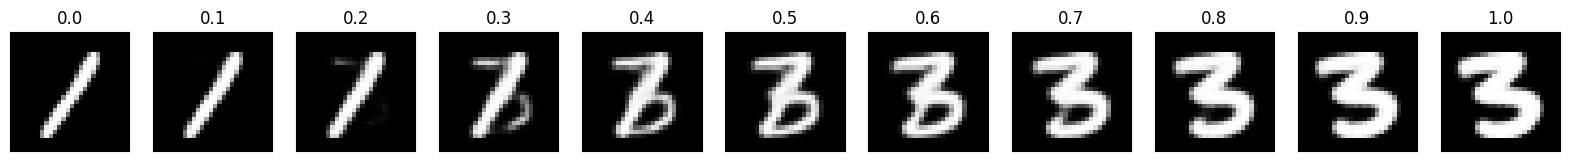

In [20]:
plt.figure(figsize=(20,4))
for i in range(11):
    plt.subplot(1,11,i+1)
    plt.imshow(gen[i].reshape(28,28),cmap='gray'); plt.xticks([]); plt.yticks([])
    plt.title(str(alpha[i]))